In [25]:
# =========================
# 1️⃣ CARGAR CSV
# =========================
import pandas as pd

# Cambia esto al nombre exacto de tu archivo CSV
csv_file = "XRPUSDTUSDT_5m_2000.csv"

# Cargar CSV
df = pd.read_csv(csv_file)

# Mostrar las primeras filas
df.head()


,timestamp,open,high,low,close,volume,datetime
0,1758007200000,2.9910,2.9912,2.9861,2.9887,472847.1416,2025-09-16 07:20:00+00:00
1,1758007500000,2.9887,2.9940,2.9887,2.9929,635275.9313,2025-09-16 07:25:00+00:00
2,1758007800000,2.9929,2.9946,2.9892,2.9945,661769.5717,2025-09-16 07:30:00+00:00
3,1758008100000,2.9945,2.9955,2.9914,2.9927,155822.2669,2025-09-16 07:35:00+00:00
4,1758008400000,2.9927,2.9964,2.9909,2.9963,324435.7385,2025-09-16 07:40:00+00:00


In [66]:
import ccxt
import pandas as pd
from datetime import datetime, timezone
import time
import os

# ----------------- CONFIG -----------------
SYMBOL = "XRP/USDT:USDT"
TIMEFRAME = "5m"
MAX_CANDLES = 2000
CSV_FILE = f"{SYMBOL.replace('/','').replace(':','')}_{TIMEFRAME}_{MAX_CANDLES}.csv"

bitget = ccxt.bitget({'enableRateLimit': True})

def fetch_n_ohlcv(exchange, symbol, timeframe='5m', limit_total=2000, limit_per_call=1000):
    timeframe_ms = exchange.parse_timeframe(timeframe) * 1000
    now_ms = exchange.milliseconds()
    since = int(now_ms - (limit_total * timeframe_ms))
    all_rows = []

    while len(all_rows) < limit_total:
        to_fetch = min(limit_per_call, limit_total - len(all_rows))
        candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=to_fetch)
        if not candles:
            break
        if all_rows and candles[0][0] <= all_rows[-1][0]:
            candles = [c for c in candles if c[0] > all_rows[-1][0]]
        if not candles:
            break
        all_rows.extend(candles)
        since = all_rows[-1][0] + timeframe_ms
        time.sleep(exchange.rateLimit/1000 if hasattr(exchange, 'rateLimit') else 0.2)

    df = pd.DataFrame(all_rows, columns=['timestamp','open','high','low','close','volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    return df.iloc[-limit_total:].reset_index(drop=True)

# ----------------- CARGAR O ACTUALIZAR CSV -----------------
if os.path.exists(CSV_FILE):
    print(f"[INFO] Cargando CSV existente: {CSV_FILE}")
    df = pd.read_csv(CSV_FILE, parse_dates=['datetime'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    # Actualizamos con velas nuevas
    last_ts = int(df['timestamp'].iloc[-1])
    new_df = fetch_n_ohlcv(bitget, SYMBOL, TIMEFRAME)
    new_df = new_df[new_df['timestamp'] > last_ts]
    if not new_df.empty:
        df = pd.concat([df, new_df], ignore_index=True)
        df.to_csv(CSV_FILE, index=False)
        print(f"[INFO] CSV actualizado con {len(new_df)} velas nuevas")
else:
    print(f"[INFO] Descargando {MAX_CANDLES} velas para {SYMBOL}")
    df = fetch_n_ohlcv(bitget, SYMBOL, TIMEFRAME, limit_total=MAX_CANDLES)
    df.to_csv(CSV_FILE, index=False)
    print(f"[INFO] CSV guardado: {CSV_FILE}")

print(df.tail(5))



[INFO] Cargando CSV existente: XRPUSDTUSDT_5m_2000.csv
[INFO] CSV actualizado con 3 velas nuevas
          timestamp    open    high     low   close       volume  \
2163  1758656100000  2.8618  2.8621  2.8557  2.8601  371179.0000   
2164  1758656400000  2.8601  2.8631  2.8592  2.8631   28783.0000   
2165  1758656700000  2.8549  2.8564  2.8495  2.8505  772209.1898   
2166  1758657000000  2.8505  2.8526  2.8478  2.8517  470632.5949   
2167  1758657300000  2.8517  2.8529  2.8463  2.8491  123502.0434   

                      datetime  
2163 2025-09-23 19:35:00+00:00  
2164 2025-09-23 19:40:00+00:00  
2165 2025-09-23 19:45:00+00:00  
2166 2025-09-23 19:50:00+00:00  
2167 2025-09-23 19:55:00+00:00  


In [68]:
# =========================
# 2️⃣ LIMPIAR Y PREPARAR DATOS
# =========================
import numpy as np

# Asegurarnos de que las columnas correctas existen
expected_cols = ['timestamp','open','high','low','close','volume','datetime']
for col in expected_cols:
    if col not in df.columns:
        print(f"[WARN] Falta columna: {col}")

# Convertir tipos
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True, errors='coerce')
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

# Ordenar por tiempo (por si acaso)
df = df.sort_values('timestamp').reset_index(drop=True)


# Eliminar última fila (no tiene siguiente vela)
df = df.iloc[:-1]



#Cálculo de indicadores técnicos
# EMA, RSI y ATR como ejemplo
df['ema_fast'] = df['close'].ewm(span=5).mean()
df['ema_slow'] = df['close'].ewm(span=20).mean()

delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss + 1e-8)
df['rsi'] = 100 - (100 / (1 + rs))

high_low = df['high'] - df['low']
high_close = (df['high'] - df['close'].shift()).abs()
low_close = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['atr'] = tr.rolling(14).mean()

# Variable objetivo: cambio porcentual siguiente vela
df['target_change'] = df['close'].pct_change().shift(-1) * 100  # porcentaje
# Variable dirección: 1 = sube, 0 = baja
df['target_dir'] = (df['target_change'] > 0).astype(int)

df.dropna(inplace=True)
df.tail(5)

,timestamp,open,high,low,close,volume,datetime,ema_fast,ema_slow,rsi,atr,target_change,target_dir
2145,2025-09-23 19:15:00+00:00,2.8628,2.8689,2.8593,2.8682,787238.7797,2025-09-23 19:15:00+00:00,2.859996,2.855185,67.494628,0.007407,-0.083676,0
2146,2025-09-23 19:20:00+00:00,2.8682,2.8684,2.8622,2.8658,316086.3597,2025-09-23 19:20:00+00:00,2.861931,2.856196,63.507885,0.007264,-0.073278,0
2147,2025-09-23 19:25:00+00:00,2.8658,2.8663,2.8609,2.8637,322164.3216,2025-09-23 19:25:00+00:00,2.862521,2.856911,65.761812,0.007193,0.020952,1
2148,2025-09-23 19:30:00+00:00,2.8637,2.8646,2.8630,2.8643,3538.0000,2025-09-23 19:30:00+00:00,2.863114,2.857614,69.330244,0.006729,-0.146633,0
2149,2025-09-23 19:35:00+00:00,2.8618,2.8621,2.8557,2.8601,371179.0000,2025-09-23 19:35:00+00:00,2.862109,2.857851,66.322122,0.006729,0.104891,1


In [60]:
#Preparar X e Y para modelo de regresión y clasificación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['open','high','low','close','volume','ema_fast','ema_slow','rsi','atr']
X = df[features]
y_reg = df['target_change']       # % cambio siguiente vela
y_clf = df['target_dir']          # dirección siguiente vela

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar entrenamiento y test (última vela reservada para predicción real)
X_train = X_scaled[:-1]
X_test = X_scaled[-1].reshape(1, -1)
y_train_reg = y_reg[:-1]
y_train_clf = y_clf[:-1]
y_real_change = y_reg.iloc[-1]      # cambio real siguiente vela
y_real_dir = y_clf.iloc[-1]
ultimo_cierre = df['close'].iloc[-2]

In [62]:
import ccxt
import pandas as pd
import time

# Inicializar exchange Bitget (solo lectura pública)
bitget = ccxt.bitget({'enableRateLimit': True, 'timeout': 15000})

def fetch_new_ohlcv(symbol, timeframe, since=None, limit=1):
    """
    Trae la(s) vela(s) más reciente(s) desde el exchange después de 'since'.
    Devuelve un DataFrame con timestamp, open, high, low, close, volume.
    """
    try:
        ohlcv = bitget.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if ohlcv:
            df = pd.DataFrame(ohlcv, columns=['timestamp','open','high','low','close','volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
            return df
        else:
            return pd.DataFrame()  # vacío si no hay nuevas velas
    except Exception as e:
        print(f"[ERROR] fetch_new_ohlcv: {e}")
        return pd.DataFrame()


In [ ]:
ultimo = df.iloc[-1]
X_last = ultimo[features].values.reshape(1,-1)
X_last_scaled = scaler.transform(X_last)

# Predicción
pred_class = clf.predict(X_last_scaled)[0]
pred_pct = reg.predict(X_last_scaled)[0]  # % cambio predicho
pred_price = ultimo['close'] * (1 + pred_pct/100)

# Traer la siguiente vela real
df_next = fetch_new_ohlcv(SYMBOL, TIMEFRAME, since=int(ultimo['timestamp']))
if not df_next.empty:
    real_close = df_next['close'].iloc[0]
    real_pct = ((real_close - ultimo['close']) / ultimo['close']) * 100
    real_dir = 1 if real_close > ultimo['close'] else 0

    diff_price = real_close - pred_price
    diff_price_pct = (diff_price / real_close) * 100

    print("\n📊 Resultados de predicción vs mercado real")
    print(f"Última vela dataset: cierre = {ultimo['close']:.4f}")
    print(f"Predicción próxima vela: {pred_pct:.2f}% → Dirección: {'Sube' if pred_class==1 else 'Baja'}")
    print(f"Precio predicho: {pred_price:.4f}")
    print(f"Real próxima vela: {real_pct:.2f}% (cierre = {real_close:.4f}) → Dirección: {'Sube' if real_dir==1 else 'Baja'}")
    print(f"dirección: {'✅' if pred_class==real_dir else '❌'}")
    print(f"Diferencia magnitud %: {abs(pred_pct - real_pct):.2f}%")
    print(f"Diferencia precio predicho vs real: {diff_price:.4f} ({diff_price_pct:.2f}%)")
else:
    print("[INFO] No hay nueva vela disponible en el exchange aún.")


c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



📊 Resultados de predicción vs mercado real
Última vela dataset: cierre = 2.8601
Predicción próxima vela: -0.03% → Dirección: Baja
Precio predicho: 2.8594
Real próxima vela: -0.18% (cierre = 2.8549) → Dirección: Baja
Error dirección: ✅
Diferencia magnitud %: 0.16%
Diferencia precio predicho vs real: -0.0045 (-0.16%)


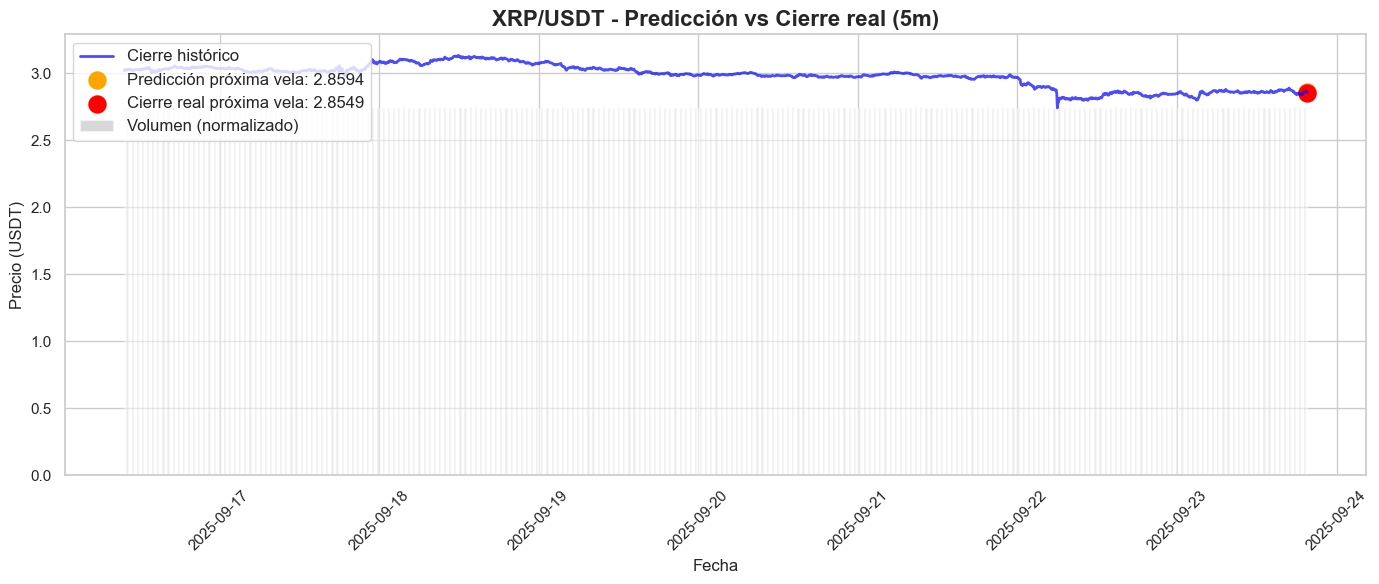

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Último cierre conocido
ultimo_cierre = df['close'].iloc[-1]

# Precio predicho de la próxima vela
pred_close = ultimo_cierre * (1 + pred_pct/100)

# Cierre real próxima vela
if not df_next.empty:
    real_close = df_next['close'].iloc[0]

# Graficar cierre histórico
plt.plot(df['datetime'], df['close'], label='Cierre histórico', color='blue', alpha=0.7, linewidth=2)

# Predicción próxima vela
plt.scatter(df['datetime'].iloc[-1], pred_close, color='orange', s=150, label=f'Predicción próxima vela: {pred_close:.4f}')

# Cierre real próxima vela
if not df_next.empty:
    plt.scatter(df['datetime'].iloc[-1], real_close, color='red', s=150, label=f'Cierre real próxima vela: {real_close:.4f}')

# Volumen como barras (opcional)
plt.bar(df['datetime'], df['volume']/df['volume'].max()* (df['close'].max()-df['close'].min())*0.5 + df['close'].min(), 
        width=0.0008, alpha=0.3, color='gray', label='Volumen (normalizado)')

# Títulos y etiquetas
plt.title(f"XRP/USDT - Predicción vs Cierre real ({TIMEFRAME})", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Precio (USDT)")

plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


